In [2]:
import pandas as pd
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
from itertools import islice
import re
import matplotlib.pyplot as plt
import tikzplotlib


def find_matching_lines(file, string):
    curLineNum=0
    lineNums=[];
    with open (file, "r") as myfile:
        for line in myfile:
            if string in line:
                lineNums.append(curLineNum)
            curLineNum = curLineNum+1

    lineNums.append(curLineNum+1)
    return lineNums
                
def pandas_read_range(file, start_linenum, end_linenum):
    df = pd.read_csv(file, skiprows=start_linenum+1, nrows=(end_linenum-start_linenum)-1) #-1 since header is not included here
    fp = open(file)
    for i, line in enumerate(fp):
        if i == start_linenum:
            header_dict=parseHeader(line)
    fp.close()
    return (header_dict, df)
            
def parseHeader(line):
    header = re.split(',', line)
    header_num_keys = len(header)
    header_keys=[]
    header_vals=[]
    for key_id in range(0, header_num_keys):
        cur_header_key = re.split('=', header[key_id])
        header_keys.append(cur_header_key[0].rstrip().lstrip())
        header_vals.append(cur_header_key[1].rstrip().lstrip())

    header_dict=dict(zip(header_keys, header_vals))
    return  header_dict

def findMatchHeaderIds(headers, headerFilter):
    matchedIdx=[]
    numHeaders=len(headers)
    for i in range(numHeaders):
        headerSet = set(headers[i])
        filterSet = set(headerFilter)
        allFilterTrue=True
        for name in headerSet.intersection(filterSet):
            #print(headers[i][name])
            pattern = re.compile(headerFilter[name])
            #pattern.match(string)
            if(bool(pattern.match(headers[i][name]))==False): #(headers[i][name] != headerFilter[name]):
                allFilterTrue=False
        if(allFilterTrue):
            matchedIdx.append(i)
    return matchedIdx

def createLegends(legendKeys, headerDict): #headerDict, filterDict):
    #headerSet = set(headerDict)
    #filterSet = set(filterDict)
    #legendKeys = list(headerSet ^ filterSet)
    legendStr = ""
    for el in legendKeys:
        legendStr+=el+"="+headerDict[el]+", "
    #print(legendStr)
    return legendStr.rstrip(', ')
    

def createPlot(axs, dfs, df_main_header_strings, xFeature, yFeature, legendKeys, headerFilter, tikzFileName):
    #Now plot
    #xFeature="Iter"
    #yFeature="errNorm"
    #legendKeys=["Matrix", "Precon subtype", "Polynomial Degree"]
    #set filters
    #headerFilter = {'Matrix': 'af_shell10', 'Precon type': 'RELAXATION', 'Threads': '20', 'Polynomial Degree': '40|80'}
    matchedIdx=findMatchHeaderIds(df_main_header_strings, headerFilter)
    #print(matchedIdx)
    legendStrs=[]
    for i in matchedIdx:
        #dfs[i].plot(x=xFeature,y=yFeature, style='.-', ax=axs)
        axs.plot(dfs[i][xFeature], dfs[i][yFeature], '.-')
        legendStrs.append(createLegends(legendKeys, df_main_header_strings[i])) #df_main_header_strings[i], headerFilter))
        #tikzplotlib.save(tikzFileName)
    axs.set_xlabel(xFeature, fontsize=16)
    axs.set_ylabel(yFeature, fontsize=16)
    #axs.legend(legendStrs)
    axs.legend("", frameon=False)
    return legendStrs
    #axs.legend(legendStrs, bbox_to_anchor=(1.0, 1.0))

       


In [3]:
#plot for GMRES paper. Only performance

import operator
import math
import numpy as np

def MG_instance(preconType, sweeps):
    #plot for all matrix
    date="6_Sept_2022"
    machine="horeka"
    threads="38"
    folder_wo_RACE="/Users/ud15idid/MPK_iterative_solvers/plots/"+machine+"/amg_results/"+date+"/"
    folder_w_RACE="/Users/ud15idid/MPK_iterative_solvers/plots/"+machine+"/amg_results_w_RACE/"+date+"/"

    tikzFileName="tikzOut.tex"

    folders=[folder_wo_RACE, folder_w_RACE]
    titles=["wo RACE", "w RACE"]
    tikzFileNames=["AMG_allMatrices_wo_RACE.tex", "AMG_allMatrices_w_RACE.tex"]
    ctr=0

    #matrices=['F1', 'parabolic_fem', 'FreeBosonChain-18', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'dielFilterV3real', 'ML_Geer', 'thermal2']
    #matrices=['F1', 'parabolic_fem', 'HPCG-128-128-128', 'Geo_1438', 'FEM_3D_thermal2', 'af_shell10', 'Emilia_923', 'Transport', 'G3_circuit', 'ldoor', 'ML_Geer', 'thermal2']
    #matrices=['G3_circuit', 'thermal2', 'af_shell7', 'Transport', 'Fault_639', 'Emilia_923', 'af_shell10',
    #          'ML_Geer', 'Flan_1565']
    matrices=['G3_circuit', 'thermal2', 'Transport', 'Fault_639', 'Emilia_923', 'af_shell10',
              'ML_Geer', 'Flan_1565']


    #preconType="gs2_2"
    #sweeps="2"
    RACEpower=".*"

    #matrices=['ML_Geer']
    #study convergence and performance
    xFeature=["Matrix"]
    fixedFeature={'Iter':(operator.eq,1000)} #only one feature allowed
    #fixedFeature={'Iter':(operator.eq,5000), 'errNorm':(operator.le,1e-12)}
    #yFeature=('errNorm', 'min') #the column and the reduction operator
    yFeature="Total_time" #the column to plot
    #yFeature="errNorm"
    #best configuration is chosen depending on min. value of err*Solve_time 
    #Note: not Total_time, because pre-processing overhead decreases with high iterations 

    legendKeys=["Matrix", "Precon type", "solverType", "sweeps", "power"]
    #set filters

    #time contributions to plot
    time_contribs=["GMRES:ortho", "GMRES:spmv", "GMRES:Prec"]

    fig, axs = plt.subplots(figsize=(12, 8))
    legends=['w/o RACE', 'RACE']
    ctr=0

    all_yData=[]
    all_timeData=[]
    all_chosenPower=[]
    for folder in folders:
        #for rcm in ["", "_RCM"]:
        for rcm in ["", ""]:
            yData=[]
            chosenPower=[]
            timeData=[None] * len(time_contribs)
            for contribIdx in range(0,len(time_contribs)):
                timeData[contribIdx] = [] #make empty list

            matrices_w_data=[]
            chosenSolveTime=[]
            #matrixNames=[]
            #find result files for matrices
            #os.chdir(folder)
            for matrix in matrices:
                matrix=matrix+rcm
                print(matrix)
                #headerFilter = {'Precon type': matrices[matrix]['Precon type'], 'Precon subtype': matrices[matrix]['Precon subtype'], 'Threads': '38', 'restartLength': matrices[matrix]['restartLength'], 'solverType': matrices[matrix]['solverType']}
                headerFilter = {'Precon type': preconType, 'Threads': threads, 'power': RACEpower, 'sweeps': sweeps}
                file=folder+matrix+".txt"
                #matrix=os.path.splitext(file)[0]
                #matrixNames.append(matrix)
                matchLineNums=find_matching_lines(file, "Matrix=")
                numMatches=len(matchLineNums)

                dfs=[]
                df_main_header_strings=[]

                for i in range(1,numMatches):
                    (header, df) = pandas_read_range(file, matchLineNums[i-1], matchLineNums[i]-1)
                    dfs.append(df)
                    df_main_header_strings.append(header)


                #print(df_main_header_strings[20]['Matrix'])

                #df = pd.read_csv(file)
                #df.head(100)
                #dfs[0].head()


                locCtr=0
                #add totalTime to dfs
                for df in dfs:
                    df['Total_time'] = df['Solve_time']+df['Precon_setup'] #+df['RACE_setup']
                    if 'RACE_setup' in df.columns:
                        df['Total_time'] += df['RACE_setup']
                    df['err_time_slope'] = df['errNorm'].diff()/df['Solve_time'].diff() #ranking cirteria
                    #print(df['ranking_slope'])
                    #print(df_main_header_strings[locCtr])
                    locCtr+=1

                #now filter based on header
                matchedIdx=findMatchHeaderIds(df_main_header_strings, headerFilter);

                curSolveTime=[]
                curYVals=[]
                timeVals=[None] * len(time_contribs)
                for contribIdx in range(0,len(time_contribs)):
                    timeVals[contribIdx] = [] #make empty list

                #filter feature depending on fixedFeature and yFeature
                for feature in fixedFeature:
                    featureOp=fixedFeature[feature][0]
                    featureVal=fixedFeature[feature][1]

                    for i in matchedIdx:
                        df=dfs[i]
                        #print(df.head())
                        filteredDf = df[featureOp(df[feature],featureVal)]
                        #print(filteredDf.head())
                        yFeatureOp=yFeature[1]
                        curYVals.extend(filteredDf[yFeature].values)
                        curSolveTime.extend(filteredDf['Solve_time'].values)
                        for contribIdx in range(0,len(time_contribs)):
                            timeVals[contribIdx].extend(filteredDf[time_contribs[contribIdx]].values)


                if (len(curYVals)!=1):
                    print(curYVals)
                    print("Warning: More than one matches. Taking minimum.") 

                #always take min, because it is time
                #minTime=np.min(np.array(curYVals))
                minIndex = np.argmin(np.array(curYVals))
                print("chosen index ", minIndex)
                #print("chosen rank ", curRanking[minErrIndex])
                chosen_header=df_main_header_strings[matchedIdx[minIndex]]
                print("chosen setting ", chosen_header)
                curPower=1
                if "power" in chosen_header:
                    curPower=chosen_header["power"]
                print("chosen power ", curPower)
                chosenPower.append(curPower)
                print("chosen yValue ", curYVals[minIndex])
                print("chosen solve time ", curSolveTime[minIndex])
                chosenSolveTime.append(curSolveTime[minIndex])
                matrices_w_data.append(matrix)
                yData.append(curYVals[minIndex])
                for contribIdx in range(0,len(time_contribs)):
                    timeData[contribIdx].append(timeVals[contribIdx][minIndex])

            print(yData)
            print(timeData)
            print("chosen Solve Time ", chosenSolveTime)
            all_yData.append(yData)
            all_timeData.append(timeData)
            all_chosenPower.append(chosenPower)
            #plt.plot(matrices_w_data, yData, '.-', label=legends[ctr])
            ctr=ctr+1

            print("matrices w data", matrices_w_data)
    #yToPlot=np.array(all_yData[0])/np.array(all_yData[1])
    yToPlot=[]
    ctr=0
    for y in all_yData[0]:
        if math.isnan(float(y)):
            all_yData[0][ctr]=np.inf
        ctr=ctr+1
    ctr=0   
    for y in all_yData[1]:
        if math.isnan(float(y)):
            all_yData[1][ctr]=np.inf
        ctr=ctr+1

    #plt.bar(matrices_w_data, all_yData[0])
    #wo_RACE_list = [plt.bar(matrices_w_data, all_yData[0], align='edge', width=-0.2)]
    #w_RACE_list = [plt.bar(matrices_w_data, all_yData[1], align='edge', width=0.2)]

    baseTime_wo_rcm=np.array(all_yData[0])
    baseTime_w_rcm=np.array(all_yData[1])
    baseTime = np.minimum(baseTime_wo_rcm, baseTime_w_rcm) #np.ones(len(all_yData[0]))
    isRCMmins = (baseTime == baseTime_w_rcm)
    ortho_time=np.zeros(len(baseTime_wo_rcm))
    spmv_time=np.zeros(len(baseTime_wo_rcm))
    prec_time=np.zeros(len(baseTime_wo_rcm))
    ctr=0
    for rcmMin in isRCMmins:
        idx=0
        if rcmMin:
            idx=1
        ortho=np.array(all_timeData[idx][0])[ctr]
        ortho_time[ctr]=ortho
        spmv=np.array(all_timeData[idx][1])[ctr]
        spmv_time[ctr]=spmv
        prec=np.array(all_timeData[idx][2])[ctr]
        prec_time[ctr]=prec
        ctr=ctr+1

    misc_time=(baseTime-(ortho_time+spmv_time+prec_time))

    barWidth=0.3

    #normalize all time
    ortho_time = ortho_time/baseTime
    spmv_time = spmv_time/baseTime
    prec_time = prec_time/baseTime
    misc_time = misc_time/baseTime

    wo_RACE_list = [plt.bar(matrices_w_data, misc_time, align='edge', width=-barWidth, color="#bdd7e7"),
                    plt.bar(matrices_w_data, ortho_time, bottom=misc_time, align='edge', width=-barWidth, color="#6baed6"),
                    plt.bar(matrices_w_data, spmv_time, bottom=(ortho_time+misc_time), align='edge', width=-barWidth, color="#3182bd"),
                    plt.bar(matrices_w_data, prec_time, bottom=(ortho_time+misc_time+spmv_time), align='edge', width=-barWidth, color="#08519c")
                   ]
    prec_wo_race=prec_time

    #idx=1
    #ortho_time=(np.array(all_timeData[idx][0])+np.array(all_timeData[idx][1]))
    #spmv_prec_time=(np.array(all_timeData[idx][2])+np.array(all_timeData[idx][3])+np.array(all_timeData[idx][4]))
    #misc_time=((np.array(all_yData[idx])-(ortho_time+spmv_prec_time)))
    raceTime_wo_rcm=np.array(all_yData[2])
    raceTime_w_rcm=np.array(all_yData[3])
    raceTime = np.minimum(raceTime_wo_rcm, raceTime_w_rcm) #np.ones(len(all_yData[0]))
    isRCMmins = (raceTime == raceTime_w_rcm)
    ortho_time=np.zeros(len(raceTime_wo_rcm))
    spmv_time=np.zeros(len(raceTime_wo_rcm))
    prec_time=np.zeros(len(raceTime_wo_rcm))
    chosen_power_selected=np.zeros(len(raceTime_wo_rcm), dtype=int)

    ctr=0
    for rcmMin in isRCMmins:
        idx=2
        if rcmMin:
            idx=3
        ortho=np.array(all_timeData[idx][0])[ctr]
        ortho_time[ctr]=ortho
        spmv=np.array(all_timeData[idx][1])[ctr]
        spmv_time[ctr]=spmv
        prec=np.array(all_timeData[idx][2])[ctr]
        prec_time[ctr]=prec
        chosen_power_selected[ctr] = all_chosenPower[idx][ctr]
        ctr=ctr+1

    misc_time=(raceTime-(ortho_time+spmv_time+prec_time))
    #normalize all time
    ortho_time = ortho_time/baseTime
    spmv_time = spmv_time/baseTime
    prec_time = prec_time/baseTime
    misc_time = misc_time/baseTime

    w_RACE_list = [plt.bar(matrices_w_data, misc_time, align='edge', width=barWidth, color="#fdbe85"),
                    plt.bar(matrices_w_data, ortho_time, bottom=misc_time, align='edge', width=barWidth, color="#fd8d3c"),
                    plt.bar(matrices_w_data, spmv_time, bottom=(ortho_time+misc_time), align='edge', width=barWidth, color="#e6550d"),
                    plt.bar(matrices_w_data, prec_time, bottom=(ortho_time+misc_time+spmv_time), align='edge', width=barWidth, color="#a63603")
                   ]
    prec_w_race=prec_time

    text_y_pos = np.zeros(len(w_RACE_list[2]))
    ctr=0
    for bars in w_RACE_list:
         ctr=0
         for bar in bars:
            text_y_pos[ctr] += bar.get_height() 
            ctr+=1

    ctr=0
    for bar in w_RACE_list[2]:
        #plt.text(bar.get_x() + bar.get_width() / 2.0, text_y_pos[ctr] + 0.05,  chosen_power_selected[ctr], ha="center", fontsize="x-large")
        ctr+=1

    #plt.bar(matrices_w_data, all_yData[1]) 
    plt.legend(['Baseline', 'RACE'])
    #axs.set_xlabel("Matrix", fontsize=16)
    plt.xticks(matrices_w_data, rotation=45, fontsize=16);
    axs.set_ylabel("Normalized time", fontsize=16)

    #yToPlot=np.minimum(all_yData[0], all_yData[1])
    avg_mpk_speedup=np.average(prec_wo_race/prec_w_race)
    print("Average MPK speedup = ", avg_mpk_speedup)
    avg_speedup=np.average(baseTime/raceTime)
    print("Average speedup = ", avg_speedup)
    #plt.plot(matrices_w_data, yToPlot, '.-')
    #plt.plot(matrices_w_data, (np.array(all_yData[0])), '.-', label="Error norm")
    tikzplotlib.save(tikzFileName)

    #axs.set_xlabel("Matrix", fontsize=16)
    #axs.set_ylabel("Time (s)", fontsize=16)
    #axs.set_ylabel("Time for convergence", fontsize=16)

    #axs.set_ylabel("Error norm", fontsize=16)
    #axs.legend()

    #axs.set_ylim([0, 1.8])
    
    return avg_speedup




G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  1.9423000000000001
chosen solve time  1.5293
thermal2
chosen index  0
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  0.9225
chosen solve time  0.6362
Transport
chosen index  0
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  5.9919
chosen solve time  5.4728
Fault_639
chosen index  0
chosen setting  {'Matrix': 'Fault_639.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  27.2343
chosen solve time  26.904
Emilia_923
chosen index  0
chosen setting  {'Matrix': 'Emilia_923.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres',

[76.2044, 71.25810000000001]
chosen index  1
chosen setting  {'Matrix': 'Flan_1565.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2', 'cacheSize': '85', 'recStage': '60', 'power': '2'}
chosen power  2
chosen yValue  71.25810000000001
chosen solve time  69.6401
[1.8942, 1.0997, 4.5632, 25.336899999999996, 29.9904, 32.4347, 64.0737, 71.25810000000001]
[[0.2, 0.0582, 0.6387, 1.9842, 2.6968, 4.4963, 4.4686, 4.6284], [0.0473, 0.0325, 0.3289, 2.4767, 3.5598, 4.6442, 9.1498, 9.8446], [0.9544, 0.4694, 2.7727, 20.0149, 22.7223, 21.8009, 48.5513, 54.6018]]
chosen Solve Time  [1.2819, 0.6056, 3.9016, 24.8493, 29.3853, 31.6481, 62.6532, 69.6401]
matrices w data ['G3_circuit', 'thermal2', 'Transport', 'Fault_639', 'Emilia_923', 'af_shell10', 'ML_Geer', 'Flan_1565']
Average MPK speedup =  1.301481913068078
Average speedup =  1.1672103946263748


1.1672103946263748

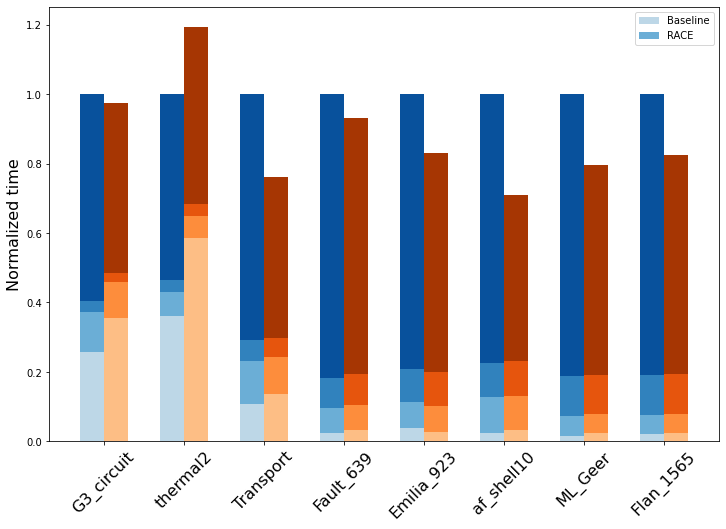

In [3]:
MG_instance("gs2_1", "2")

G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  2.3078000000000003
thermal2
chosen index  0
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  0.9714
Transport
chosen index  0
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  6.2271
Fault_639
chosen index  0
chosen setting  {'Matrix': 'Fault_639.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  19.7897
Emilia_923
chosen index  0
chosen setting  {'Matrix': 'Emilia_923.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  24.6467
af_shell10
chosen index  0
chosen setting  {'Matr

G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  2.1521
thermal2
chosen index  0
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  0.9077
Transport
chosen index  0
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  5.518800000000001
Fault_639
chosen index  0
chosen setting  {'Matrix': 'Fault_639.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  22.9774
Emilia_923
chosen index  0
chosen setting  {'Matrix': 'Emilia_923.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '1'}
chosen power  1
chosen yValue  29.351200000000002
af_shell10
chosen index  0
chosen setti

G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  1.9423000000000001
thermal2
chosen index  0
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  0.9225
Transport
chosen index  0
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  5.9919
Fault_639
chosen index  0
chosen setting  {'Matrix': 'Fault_639.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  27.2343
Emilia_923
chosen index  0
chosen setting  {'Matrix': 'Emilia_923.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  36.168400000000005
af_shell10
chosen index  0
chosen sett

G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  2.0191999999999997
thermal2
chosen index  0
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  0.9943
Transport
chosen index  0
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  6.0751
Fault_639
chosen index  0
chosen setting  {'Matrix': 'Fault_639.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  32.602199999999996
Emilia_923
chosen index  0
chosen setting  {'Matrix': 'Emilia_923.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  43.144
af_shell10
chosen index  0
chosen setti

[86.29520000000001, 90.40520000000001]
chosen index  0
chosen setting  {'Matrix': 'Flan_1565.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '2', 'cacheSize': '85', 'recStage': '0', 'power': '2'}
chosen power  2
chosen yValue  86.29520000000001
[1.8778000000000001, 1.1508, 4.7877, 29.5552, 37.0598, 36.7678, 80.494, 86.29520000000001]
[[0.1727, 0.0511, 0.5801, 1.9475, 2.9775, 4.6492, 4.494, 4.6643], [0.0472, 0.0294, 0.3106, 2.4986, 3.5242, 4.6757, 9.2401, 9.9211], [1.0366, 0.5411, 3.0753, 22.954, 29.5405, 26.1297, 64.8225, 69.8366]]
matrices w data ['G3_circuit', 'thermal2', 'Transport', 'Fault_639', 'Emilia_923', 'af_shell10', 'ML_Geer', 'Flan_1565']
Average MPK speedup =  1.3071536160195716
Average speedup =  1.189359348754294
G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '3'}
chosen power  1
chosen yValue  2.2186
thermal2
chosen index  0
chosen setting  

[87.1305, 88.07180000000001]
chosen index  0
chosen setting  {'Matrix': 'ML_Geer.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '3', 'cacheSize': '85', 'recStage': '0', 'power': '3'}
chosen power  3
chosen yValue  87.1305
Flan_1565
[97.4333, 115.3179]
chosen index  0
chosen setting  {'Matrix': 'Flan_1565.mtx', 'Threads': '38', 'Precon type': 'gs2_1', 'solverType': 'gmres', 'sweeps': '3', 'cacheSize': '85', 'recStage': '0', 'power': '3'}
chosen power  3
chosen yValue  97.4333
[2.1593999999999998, 1.2524, 5.3141, 30.886599999999998, 41.2331, 39.3554, 87.1305, 97.4333]
[[0.1629, 0.0479, 0.5579, 1.9475, 2.762, 4.5258, 4.425, 4.6832], [0.0445, 0.0294, 0.2976, 2.5733, 3.5359, 4.5898, 9.1825, 10.0657], [1.099, 0.5853, 3.6485, 25.5112, 33.9202, 28.8669, 71.5989, 80.5966]]
matrices w data ['G3_circuit', 'thermal2', 'Transport', 'Fault_639', 'Emilia_923', 'af_shell10', 'ML_Geer', 'Flan_1565']
Average MPK speedup =  1.261481112057425
Average speedup =  1.161313146

[54.6538, 54.928799999999995]
chosen index  0
chosen setting  {'Matrix': 'af_shell10.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '3', 'cacheSize': '85', 'recStage': '0', 'power': '3'}
chosen power  3
chosen yValue  54.6538
ML_Geer
[118.28260000000002, 130.1457]
chosen index  0
chosen setting  {'Matrix': 'ML_Geer.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '3', 'cacheSize': '85', 'recStage': '0', 'power': '3'}
chosen power  3
chosen yValue  118.28260000000002
Flan_1565
[114.28320000000001, 164.11829999999998]
chosen index  0
chosen setting  {'Matrix': 'Flan_1565.mtx', 'Threads': '38', 'Precon type': 'gs2_2', 'solverType': 'gmres', 'sweeps': '3', 'cacheSize': '85', 'recStage': '0', 'power': '3'}
chosen power  3
chosen yValue  114.28320000000001
[1.8976000000000002, 1.2650000000000001, 5.713, 35.6677, 47.86750000000001, 54.6538, 118.28260000000002, 114.28320000000001]
[[0.1186, 0.0401, 0.5115, 2.065, 2.7531, 4.5541, 4

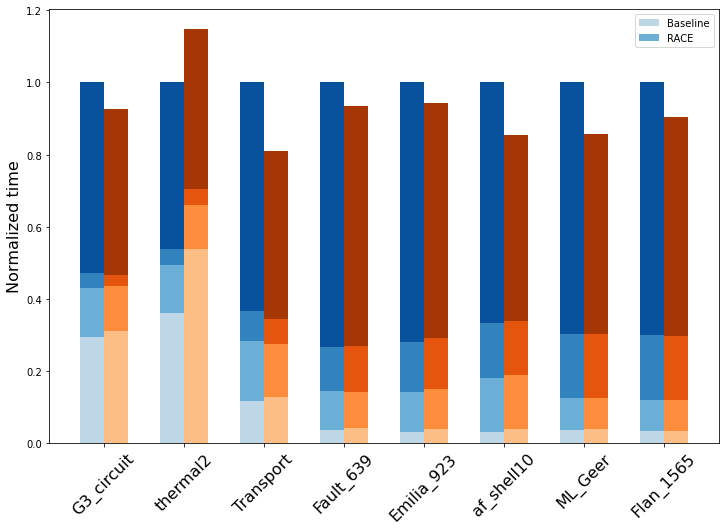

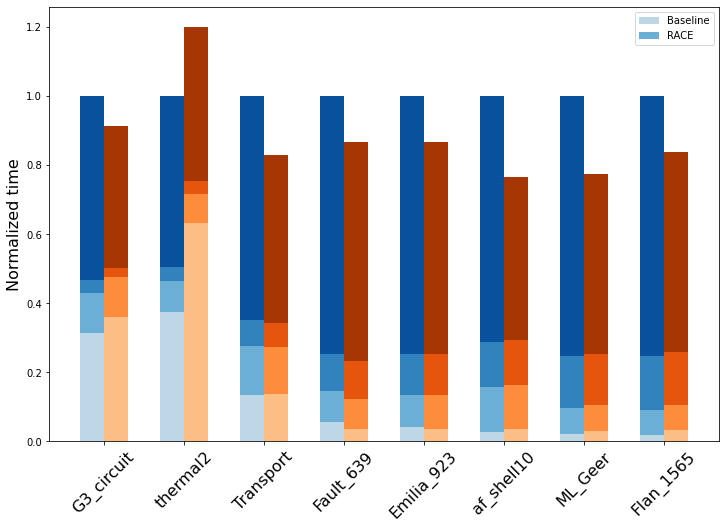

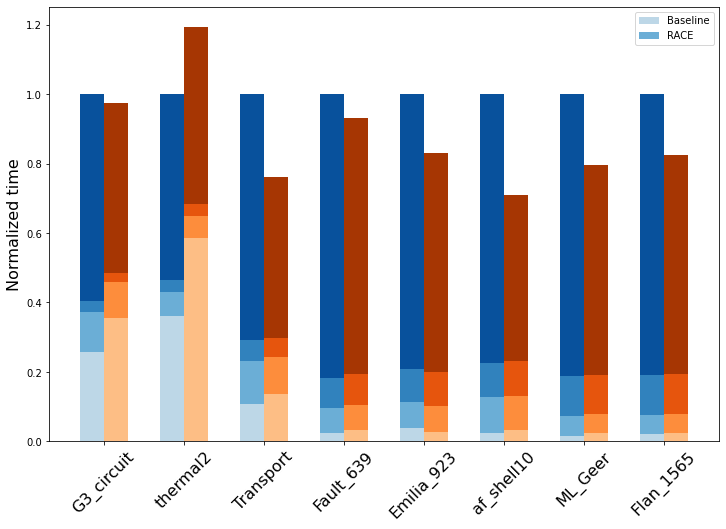

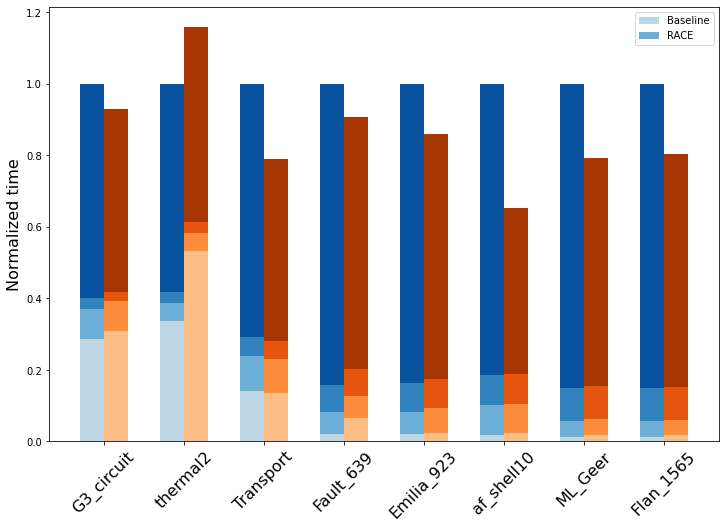

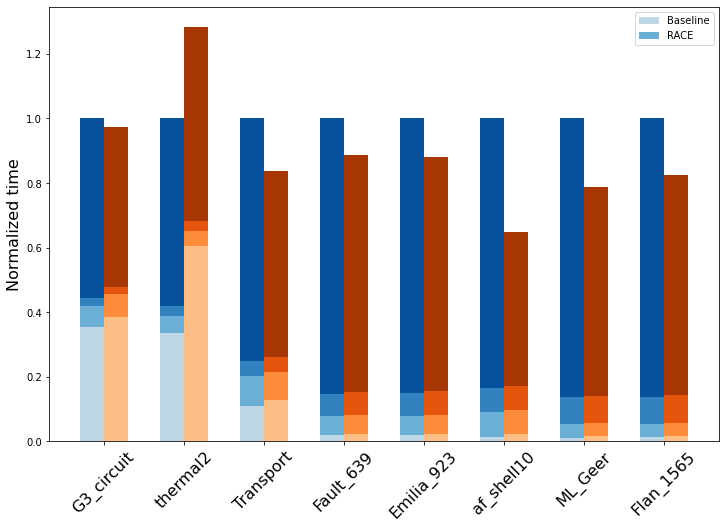

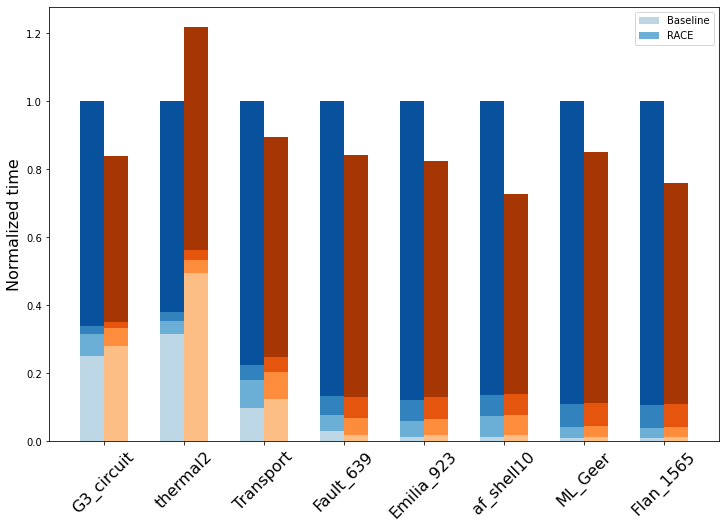

In [41]:
outerSweeps=[1, 2, 3]
innerSweeps=[1,2]

resOut=np.zeros([len(outerSweeps), len(innerSweeps)])
for i in outerSweeps:
    for j in innerSweeps:
        resOut[i-1,j-1]=MG_instance("gs2_"+str(j), str(i))
        
print(resOut)

G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  1.2071
thermal2
chosen index  0
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  1.6479
Transport
chosen index  0
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  3.5633
Fault_639
chosen index  0
chosen setting  {'Matrix': 'Fault_639.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  18.4637
Emilia_923
chosen index  0
chosen setting  {'Matrix': 'Emilia_923.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '2'}
chosen power  1
chosen yValue  28.9525
af_shell10
chosen index  0
chosen setting  {'Matrix': 'af_shell10.

G3_circuit
chosen index  0
chosen setting  {'Matrix': 'G3_circuit.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '3'}
chosen power  1
chosen yValue  0.9945999999999999
thermal2
chosen index  0
chosen setting  {'Matrix': 'thermal2.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '3'}
chosen power  1
chosen yValue  1.1878
Transport
chosen index  0
chosen setting  {'Matrix': 'Transport.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '3'}
chosen power  1
chosen yValue  3.383
Fault_639
chosen index  0
chosen setting  {'Matrix': 'Fault_639.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '3'}
chosen power  1
chosen yValue  22.6283
Emilia_923
chosen index  0
chosen setting  {'Matrix': 'Emilia_923.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '3'}
chosen power  1
chosen yValue  36.645900000000005
af_shell10
chosen index  0
chosen setting  {

[47.1457, 47.114599999999996]
chosen index  1
chosen setting  {'Matrix': 'ML_Geer.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '3', 'cacheSize': '200', 'recStage': '40', 'power': '4'}
chosen power  4
chosen yValue  47.114599999999996
Flan_1565
[52.4213, 52.3489]
chosen index  1
chosen setting  {'Matrix': 'Flan_1565.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '3', 'cacheSize': '200', 'recStage': '40', 'power': '4'}
chosen power  4
chosen yValue  52.3489
[1.0925, 1.212, 3.0717, 19.3093, 25.852600000000002, 28.6108, 47.114599999999996, 52.3489]
[[0.0734, 0.1668, 0.448, 1.3027, 2.1493, 4.1151, 4.0927, 4.2886], [0.0426, 0.0702, 0.303, 3.1443, 4.1562, 5.2636, 10.1695, 10.9062], [0.523, 0.5228, 1.7445, 14.2255, 18.7257, 18.1916, 31.2873, 35.6009]]
matrices w data ['G3_circuit', 'thermal2', 'Transport', 'Fault_639', 'Emilia_923', 'af_shell10', 'ML_Geer', 'Flan_1565']
Average MPK speedup =  1.5878437004880577
Average speedup =

[29.884800000000002, 29.9281]
chosen index  0
chosen setting  {'Matrix': 'af_shell10.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '4', 'cacheSize': '200', 'recStage': '0', 'power': '5'}
chosen power  5
chosen yValue  29.884800000000002
ML_Geer
[49.416, 49.4942]
chosen index  0
chosen setting  {'Matrix': 'ML_Geer.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '4', 'cacheSize': '200', 'recStage': '0', 'power': '5'}
chosen power  5
chosen yValue  49.416
Flan_1565
[56.4125, 58.093]
chosen index  0
chosen setting  {'Matrix': 'Flan_1565.mtx', 'Threads': '64', 'Precon type': 'cheb', 'solverType': 'gmres', 'sweeps': '4', 'cacheSize': '200', 'recStage': '0', 'power': '5'}
chosen power  5
chosen yValue  56.4125
[1.1445, 1.1448, 2.7798999999999996, 20.843500000000002, 28.4203, 29.884800000000002, 49.416, 56.4125]
[[0.0672, 0.1184, 0.3531, 1.3069, 2.1405, 4.1154, 4.0953, 4.2962], [0.0449, 0.0607, 0.2633, 3.1268, 4.1238, 5.255, 10.18

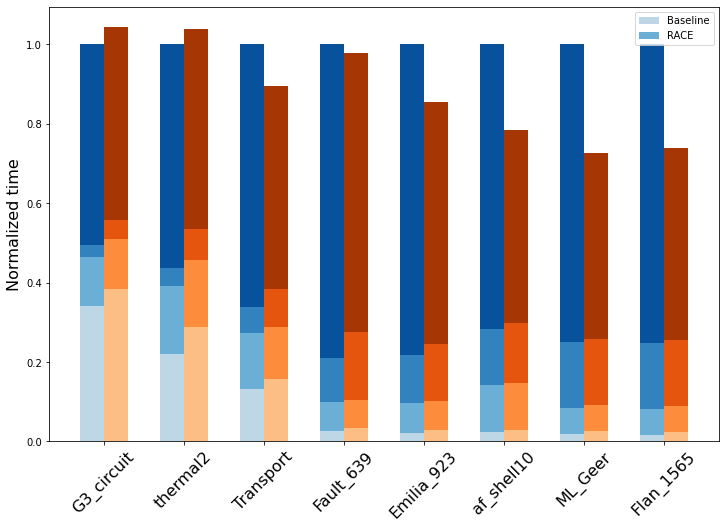

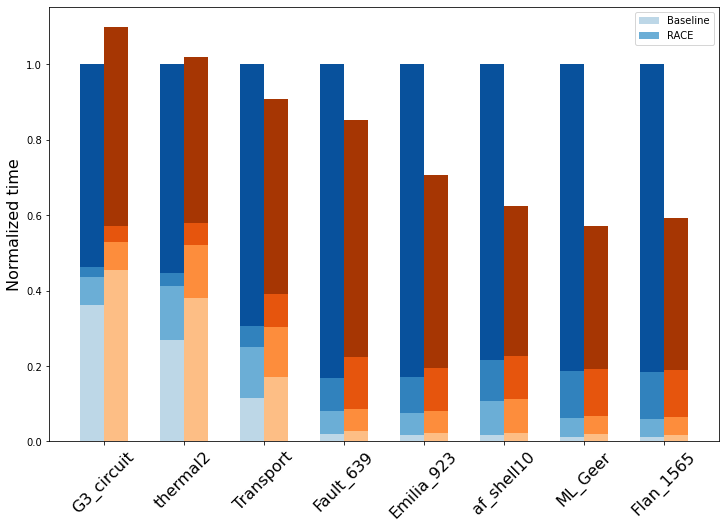

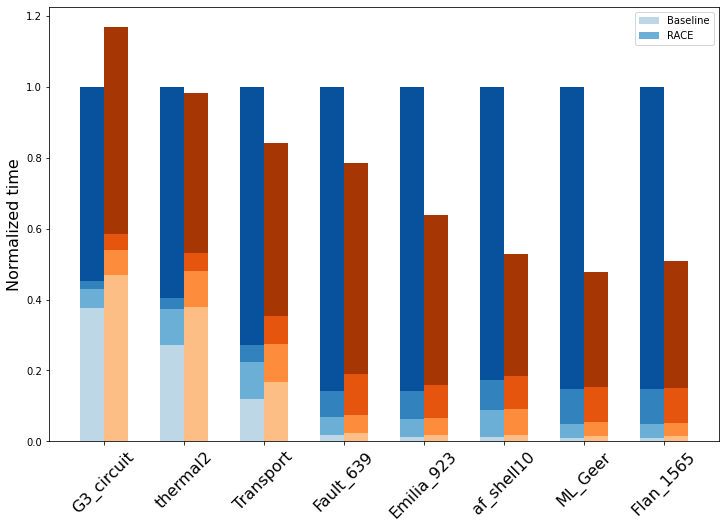

In [35]:
outerSweeps=[2, 3, 4]

resOut=np.zeros(len(outerSweeps))
ctr=0
for i in outerSweeps:
    resOut[ctr]=MG_instance("cheb", str(i))
    ctr=ctr+1
        
print(resOut)